In [258]:
from collections import defaultdict

import gseapy as gp
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 200)

import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scripts import aesthetics
from scripts import manuscript_colors as mc

aesthetics.activate_paper_rcParams('illustrator')

# GTEX analysis

Alright, let's do this. Should be quite easy since GTEX is so well documented and defined.

The goal of this analysis is extremely simple--identify the subset of genes that are affected in cases, controls, and all variations therein. Then, examine if adrenal tissue is enriched for these genes by using GTEX to assess its rank in expression.

# Load SV-related data

We need to load all the SVs and the genes they affect. Thankfully, we generated this in a previous notebook, so we can just use that data.

In [288]:
# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz"

gene_ref_path = "data/CWAS data for Jett/gencode_hg38_protein_coding_genes_for_annotation_7_31_23 (1).txt"

In [289]:
gene_ref = pd.read_csv(gene_ref_path)
gene_ref = gene_ref[~gene_ref["value"].str.startswith("ENSG00")]
gene_ref = sorted(set(gene_ref["value"].tolist()))
len(gene_ref)

19201

## Metadata and reference counts

Load metadata and SVs

In [290]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

###############
### Samples ###
###############
samples = defaultdict(dict)

total_samples = []
for disease in ["neuroblastoma", "ewing", "osteosarcoma"]:
    for cohort in ["case", "control"]:
        disease_cohort_samples = metadata[(metadata[f"{disease}_{cohort}"] == True)][
            "entity:sample_id"
        ].tolist()

        samples[disease][cohort] = disease_cohort_samples
        total_samples += disease_cohort_samples

        print(disease, cohort, len(disease_cohort_samples))

total_samples = sorted(set(total_samples))

neuroblastoma case 688
neuroblastoma control 4831
ewing case 775
ewing control 4574
osteosarcoma case 284
osteosarcoma control 4817


In [291]:
len(total_samples)

6727

Now we load the SVs. These are reference counts generated in `cwas-gene-set-enrichment`

In [292]:
ref_counts = pd.read_csv("data/cwas-results/reference-counts.csv")
ref_counts = ref_counts[ref_counts['gene'].isin(gene_ref)]

In [293]:
ref_counts.head(2)

,name,dose,gene,disease,sv_category,cohort
0,PedSV.2.5.2_DEL_chr1_80,0,SAMD11,neuroblastoma,coding,case
1,PedSV.2.5.2_DEL_chr1_100,1,PLEKHN1,neuroblastoma,coding,case


## Add a label for various SV traits

Previously, we had relied on the reference count matrix for these labels, but it led to all sorts of problems. We define them based on where they should be defined - the original SV bed file

In [294]:
sv_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.sites.bed.gz"
sv_cols = pd.read_csv(sv_path, sep = '\t', nrows = 0)
cols_to_include = ['name', 'AC', 'gnomad_v3.1_sv_POPMAX_AF']
cols_to_include_idx = [i for i, c in enumerate(sv_cols.columns) if c in cols_to_include]

svs = pd.read_csv(sv_path, sep = '\t', usecols = cols_to_include_idx)

In [295]:
singleton_svs = svs[(svs['AC'] == 1) & (svs['gnomad_v3.1_sv_POPMAX_AF'].fillna(0) < 0.01)]['name']

In [296]:
ref_counts['global_singleton'] = ref_counts['name'].isin(singleton_svs)

## Read in the category results

I'm going to concatenate all this data so that I'm only dealing with a few files.

In [297]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/CWAS data for Jett/List of variants by category/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t").rename(columns={"emd": "end"})
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_455,chr1,6720524,6722070,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_and_osteosarcoma_atac_peaks.PREDICTED_INTERGENIC.lof_constrained.expressed_in_muscle_skeletal.protein_coding,ewing,noncoding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_and_osteosarcoma_atac_peaks.PREDICTED_INTERGENIC.lof_constrained.expressed_in_muscle_skeletal.protein_coding,ewing,noncoding


In [298]:
#########################
### FRAMEWORK RESULTS ###
#########################
framework_results = []
for file in glob.glob("data/CWAS data for Jett/CWAS sum stats/*.txt"):
    if "12_26_23" not in file:
        continue

    disease = file.split("/")[-1].split("_")[0]
    
    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"
    af_category = "singleton" if "SINGLETON" in file else "rare"

    data = pd.read_csv(file, sep="\t")
    data[["disease", "sv_category", "af_category"]] = [
        disease,
        sv_category,
        af_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)

# add p values

p_val_cutoffs = {
    "neuroblastoma_coding": 0.05 / 279,
    "neuroblastoma_noncoding": 0.05 / 940,
    "ewing_coding": 0.05 / 267,
    "ewing_noncoding": 0.05 / 916,
}

framework_results["bonferroni_significant"] = framework_results.apply(
    lambda row: row["p_value"]
    < p_val_cutoffs[row["disease"] + "_" + row["sv_category"]],
    axis=1,
)

In [299]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/CWAS data for Jett/CWAS frameworks/*.txt"):

    sv_category = "noncoding" if "noncoding" in file else "coding"
    suffix = file.split("/")[-1]
    if sv_category == "coding":
        disease = suffix.split('_')[2]
    else:
        disease = suffix.split('_')[3]

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

In [300]:
framework_schema["ewing"]["noncoding"].head(2)

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,ewing_and_osteosarcoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_muscle_skeletal,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,ewing_chromHMM15_EnhBiv,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs


# Define GTEX data

In [301]:
gtex = pd.read_csv('data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz', comment = '#', sep = '\t', skiprows = 2).rename(columns = {'Description': 'gene'})
gtex.head(2)

,Name,gene,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra,Breast - Mammary Tissue,Cells - Cultured fibroblasts,Cells - EBV-transformed lymphocytes,Cervix - Ectocervix,Cervix - Endocervix,Colon - Sigmoid,Colon - Transverse,Esophagus - Gastroesophageal Junction,Esophagus - Mucosa,Esophagus - Muscularis,Fallopian Tube,Heart - Atrial Appendage,Heart - Left Ventricle,Kidney - Cortex,Kidney - Medulla,Liver,Lung,Minor Salivary Gland,Muscle - Skeletal,Nerve - Tibial,Ovary,Pancreas,Pituitary,Prostate,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,ENSG00000223972.5,DDX11L1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.166403,0.00000,0.00000,0.00000,0.00000
1,ENSG00000227232.5,WASH7P,4.06403,3.37111,2.68549,4.04762,3.90076,3.63963,5.16375,1.43859,1.69285,1.56605,4.99231,5.72099,2.48317,2.14667,1.68599,1.74811,1.53899,1.44167,2.73049,1.74194,4.43876,1.6786,2.49477,5.62935,7.09749,4.64777,3.59509,4.32641,3.11749,4.10335,6.13409,1.52031,0.924962,2.77081,2.21451,1.76541,4.50841,3.52767,1.41667,6.68531,6.6341,1.80871,5.42546,7.08318,5.93298,6.13265,4.19378,5.92631,3.06248,4.702530,6.27255,7.19001,5.74554,2.64743


Based on this link, https://gtexportal.org/home/tissueSummaryPage, GTEX uses gencode v26

What's the overlap between genes here and genes in our reference gene set?

In [302]:
len(set(gene_ref) - set(gtex['gene']))

1004

After some digging, this is because we dropped the `ENGS` genes (there is only 1 missing gene when these genes are added back). I'm fine to ignore these for now.

In [303]:
# drop ENGS ids
gtex = gtex.iloc[:, 1:]

gtex = gtex[gtex['gene'].isin(gene_ref)]

gtex = gtex.set_index('gene')

# genes need expression in at least 10% of histologies
gtex = gtex[(gtex != 0).mean(axis = 1) > 0.10]

In [304]:
gtex.shape

(17162, 54)

Now convert to normalized ranks (0 - 1, where 1 is high)

In [305]:
gtex_ranks = (gtex.rank(ascending = True, axis = 1) - 1) / 53  

In [306]:
gtex_ranks = gtex_ranks.reset_index()

# Visualize ranks directly

In [310]:
singleton_coding_ref_counts = ref_counts.query('global_singleton == True & sv_category == "coding" & dose == 1')
singleton_coding_ref_counts = singleton_coding_ref_counts.merge(gtex_ranks, on = 'gene')

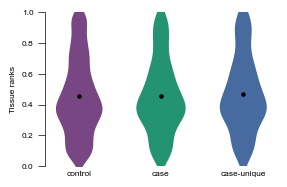

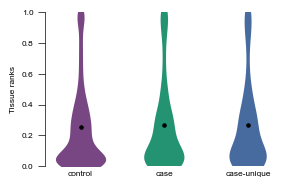

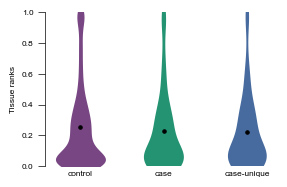

In [311]:
for disease, tissue in zip(['neuroblastoma', 'ewing', 'osteosarcoma'], 
                           ['Adrenal Gland', 'Muscle - Skeletal', 'Muscle - Skeletal']):
    fig, ax = plt.subplots(1, figsize = (3, 2))

    sns.violinplot(x = 'cohort', y = tissue, data = singleton_coding_ref_counts.query(f'disease == "{disease}"'), 
                   order = ['control', 'case', 'case_unique'],
                   width = 0.6, linewidth=0)
    
    means = singleton_coding_ref_counts.query(f'disease == "{disease}"').groupby('cohort')[tissue].mean().loc[['control', 'case', 'case_unique']]
    ax.scatter(x = [0, 1, 2], y = means, color = 'black', s = 6)
    
    aesthetics.strip_axis(ax = ax, y = 'ignore', x = 'label')

    ax.set_xlabel('')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Tissue ranks')

    ax.set_xticklabels(['control', 'case', 'case-unique'], fontsize = 6)

In [312]:
for disease, tissue in zip(['neuroblastoma', 'ewing', 'osteosarcoma'], 
                           ['Adrenal Gland', 'Muscle - Skeletal', 'Muscle - Skeletal']):
    data = singleton_coding_ref_counts.query(f'disease == "{disease}"')
    print(data.groupby('cohort')[tissue].mean())
    
    print(stats.mannwhitneyu(data.query('cohort == "case_unique"')[tissue], 
                             data.query('cohort == "control"')[tissue]))
    print()

cohort
case           0.452252
case_unique    0.468125
control        0.455580
Name: Adrenal Gland, dtype: float64
MannwhitneyuResult(statistic=869478.5, pvalue=0.2660437237847313)

cohort
case           0.265810
case_unique    0.268858
control        0.255910
Name: Muscle - Skeletal, dtype: float64
MannwhitneyuResult(statistic=944880.0, pvalue=0.5216867883190435)

cohort
case           0.229075
case_unique    0.222782
control        0.255286
Name: Muscle - Skeletal, dtype: float64
MannwhitneyuResult(statistic=292542.5, pvalue=0.2919169937100393)



# Examine instead differences in mean rank

We have to bootstrap confidence intervals for these

In [313]:
# bs_results = []
# for disease, tissue in zip(['neuroblastoma', 'ewing', 'osteosarcoma'], 
#                            ['Adrenal Gland', 'Muscle - Skeletal', 'Muscle - Skeletal']):
    
#     data = singleton_coding_ref_counts.query(f'disease == "{disease}"')[['cohort', tissue]]

#     for cohort in ['gtex', 'control', 'case', 'case_unique']:
    
#         if cohort == 'gtex':
#             values = gtex_ranks[tissue].values
#         else:
#             values = data.query(f'cohort == "{cohort}"')[tissue].values
            
#         mean = values.mean()

#         bs_dataset = np.random.choice(values, size = (len(values), 100000))
#         bs_means = bs_dataset.mean(axis = 1)
#         upper_low = np.percentile(bs_means, [2.5, 97.5])

#         bs_results.append([disease, cohort, mean] + list(upper_low))
                    
# bs_results = pd.DataFrame(bs_results, columns = ['disease', 'cohort', 'mean', 'bs_lower', 'bs_upper'])

In [314]:
# fig, axes = plt.subplots(1, 2, figsize = (5, 2), gridspec_kw = {'wspace': 0.5})
# for i, disease in enumerate(['neuroblastoma', 'ewing', 'osteosarcoma']):
#     ax = axes[i]
#     data = bs_results.query(f'disease == "{disease}"').reset_index()
#     sns.scatterplot(x = 'cohort', y = 'mean', data = data, ax = ax)
    
#     for index, row in data.iterrows():
#         mean = row['mean']
#         upper, lower = row[['bs_upper', 'bs_lower']].values
#         ax.plot([index, index], [lower, upper], color = 'darkgrey', zorder = -1)
        
#     aesthetics.strip_axis(ax = ax, x = 'label', y = 'ignore')
#     ax.set_xlabel('')
#     ax.set_xlim([-0.5, 3.5])
    
# fig.savefig('images/gtex-ranks-by-cohort.png', bbox_inches = 'tight')

What about being in the top 10% of genes?

In [315]:
# topn_results = []
# for disease, tissue in zip(['neuroblastoma', 'ewing', 'osteosarcoma'], 
#                            ['Adrenal Gland', 'Muscle - Skeletal', 'Muscle - Skeletal']):
    
#     data = singleton_coding_ref_counts.query(f'disease == "{disease}"').copy()
#     topn_genes = gtex_ranks.sort_values(by = tissue, ascending = False).index[:1000].to_list()

#     data['topn'] = data['gene'].isin(topn_genes)
#     print(data.groupby('cohort')['topn'].mean())
#     print('')

## Examine absolute expression

In [316]:
singleton_coding_ref_exp = ref_counts.query('dose == 1 & sv_category == "coding" & global_singleton == True')
singleton_coding_ref_exp = singleton_coding_ref_exp.merge(gtex.reset_index(), on = 'gene')

Let's make this into a nice figure

In [318]:
tpm_violin_data = []
for disease, tissue in zip(['neuroblastoma', 'ewing', 'osteosarcoma'], 
                           ['Adrenal Gland', 'Muscle - Skeletal', 'Muscle - Skeletal']):
    
    disease_data = singleton_coding_ref_exp.query(f'disease == "{disease}"').copy()
    
    # get the baseline
    baseline = gtex.reset_index()[['gene', tissue]]
    baseline['disease'] = disease
    baseline['name'] = np.nan
    baseline['cohort'] = 'all genes'
    
    baseline = baseline.rename(columns = {tissue: 'tissue'})
    
    tpm_violin_data.append(baseline)
    
    for cohort in ['control', 'case', 'case_unique']:
        cohort_data = disease_data.query(f'cohort == "{cohort}"')[['gene', tissue, 'disease', 'cohort', 'name']]
        cohort_data = cohort_data.rename(columns = {tissue: 'tissue'})
        tpm_violin_data.append(cohort_data)
        
        if cohort == 'control':
            case_data = disease_data.query(f'cohort == "case"')
            control_unique = cohort_data[~cohort_data['gene'].isin(case_data['gene'].tolist())].copy()
            control_unique['cohort'] = 'control_unique'
            tpm_violin_data.append(control_unique)
        
tpm_violin_data = pd.concat(tpm_violin_data)
tpm_violin_data['logTPM'] = np.log10(tpm_violin_data['tissue'] + 1)

# additionally, I want to add singleton LoF deletions
test_cats = ['DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding',
             'DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding']
for i, disease in enumerate(['neuroblastoma', 'ewing']):
    cat = test_cats[i]
    disease_cat_svs = category_svs[(category_svs['category'] == cat) &
                                   (category_svs['disease'] == disease) &
                                   (category_svs['sv_category'] == "coding")].copy()
    
    # subset our TPM data to this subset from case unique
    sv_tpms = tpm_violin_data[(tpm_violin_data['cohort'] == "case_unique") &
                              (tpm_violin_data['disease'] == disease) &
                              (tpm_violin_data['name'].isin(disease_cat_svs['SV'].tolist()))].copy()
    
    sv_tpms['cohort'] = 'lof_dels'
    
    tpm_violin_data = pd.concat([tpm_violin_data, sv_tpms])

Now we make this figure

In [321]:
palette = {'neuroblastoma': {'control': 'lightgrey', 
                             'case': mc.palette['neuroblastoma']['light2'],
                             'case_unique': mc.palette['neuroblastoma']['main'],
                             'lof_dels': mc.palette['neuroblastoma']['dark1'],
                             'control_unique': 'darkgrey'},
           'ewing': {'control': 'lightgrey', 
                     'control_unique': 'darkgrey',
                     'case': mc.palette['ewing']['light2'],
                     'case_unique': mc.palette['ewing']['main'],
                     'lof_dels': mc.palette['ewing']['dark1']},
           'osteosarcoma': {'control': 'lightgrey', 
                            'control_unique': 'darkgrey',
                     'case': mc.palette['osteosarcoma']['light2'],
                     'case_unique': mc.palette['osteosarcoma']['main']}
          }

neuroblastoma control 0.6754226976586122
neuroblastoma control_unique 0.6936979363798916
neuroblastoma case 0.7410940569325375
neuroblastoma case_unique 0.8855859928736824
MannwhitneyuResult(statistic=662286.0, pvalue=1.924082504904203e-05)
ewing control 0.4141890016082266
ewing control_unique 0.4265763193351715
ewing case 0.463168560991575
ewing case_unique 0.5764081596024176
MannwhitneyuResult(statistic=777796.5, pvalue=0.00832564733874229)


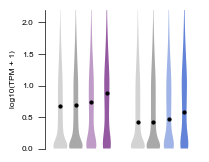

In [368]:
fig, axes = plt.subplots(1, 2, figsize = (2.0, 1.8), gridspec_kw = {'wspace': 0}, sharey = True)

for i, disease in enumerate(['neuroblastoma', 'ewing']):
    ax = axes[i]

    disease_data = tpm_violin_data.query(f'disease == "{disease}"')
    
    pal = palette[disease]

    violin = sns.violinplot(x = 'cohort', y = 'logTPM', data = tpm_violin_data, ax = ax,
                            order = ['control', 'control_unique', 'case', 'case_unique'], width = 0.9, linewidth=0, 
                            cut = 0, palette = pal)
    
    tpms = []
    for j, cohort in enumerate(['control', 'control_unique', 'case', 'case_unique']):
        cohort_data = disease_data.query(f'cohort == "{cohort}"')
        
        median = cohort_data['logTPM'].median()
        ax.scatter([j], [median], s = 5, color = 'black')
        
        tpms.append(cohort_data['logTPM'])
        
        print(disease, cohort, median)
    
    # calculate p value - case unique to control unique
    # bootstrap it
    # bs_control = np.random.choice(tpms[1], size = (len(tpms[3]), 1000000), replace = True)

    p = stats.mannwhitneyu(tpms[1], tpms[3])
    print(p)
    
    
    ax.set_ylim([0, 2.2])
    ax.set_xlim([-1, 4])
    ax.set_ylabel('log10(TPM + 1)')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
    if i == 0:
        aesthetics.strip_axis(ax = ax, y = 'ignore', x = 'label')
        
    else:
        aesthetics.strip_axis(ax = ax, x = 'label')
        
fig.savefig('images/expression-violin-plot.pdf', bbox_inches = 'tight')

In [382]:
tpm_violin_data.groupby(['disease', 'cohort'])['tissue'].mean()

disease        cohort        
ewing          all genes          28.963835
               case               25.337750
               case_unique        31.405412
               control            16.430690
               control_unique     16.600041
               lof_dels           17.903298
neuroblastoma  all genes          25.915707
               case               15.567674
               case_unique        21.382931
               control            15.298261
               control_unique     16.151310
               lof_dels           18.430421
osteosarcoma   all genes          28.963835
               case              107.705787
               case_unique       185.269774
               control            18.125572
               control_unique     18.542571
Name: tissue, dtype: float64

# Define tissue-specific gene sets

In [34]:
replace_dict = {' - ': ' ', ' ': '-', '(': '', ')': ''}
with open('data/gtex-tissue-specific-gene-sets.txt', 'w') as out:
    for tissue in gtex_ranks.columns[1:]:
        for cutoff in [100, 200, 500]:
            for label, d in zip(['rank', 'exp'], [gtex_ranks, gtex]):
                tissue_genes = d.reset_index().sort_values(by = tissue, ascending = False)['gene'][:cutoff]
                
                gs_name = f'{tissue}-{label}-{cutoff}'
    
                for char, char_map in replace_dict.items():
                    gs_name = gs_name.lower().replace(char, char_map)
                
                out.write(f'{gs_name} | ' + ','.join(tissue_genes) + '\n')